# Algoritmos de Clasificación Avanzados

## ¿De qué trata este notebook?

Exploraremos 4 algoritmos populares para clasificación:

1. **KNN (K-Vecinos Más Cercanos)**: Muy simple - pregunta a los vecinos más cercanos
2. **Árbol de Decisión**: Como un árbol de decisiones ("¿es joven?" → "¿tiene síntomas?")
3. **Bosque Aleatorio**: Muchos árboles votando juntos
4. **SVM (Máquinas de Vectores)**: Encuentra el mejor divisor entre clases

Todos aprenderán del mismo conjunto de datos: Predecir cáncer basado en edad y biomarcador

## 1. Importar Librerías y Preparar Datos

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [5]:
# Generar datos sintéticos (dataset de cáncer)
np.random.seed(42)

n_samples = 200

# Características
edad = np.random.uniform(20, 80, n_samples)
biomarcador = np.random.uniform(0, 100, n_samples)

# Clase
probabilidad_cancer = (edad / 80) * 0.5 + (biomarcador / 100) * 0.5
y = (probabilidad_cancer + np.random.normal(0, 0.1, n_samples)) > 0.5
y = y.astype(int)

X = np.column_stack([edad, biomarcador])

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de Entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de Prueba: {X_test.shape[0]} muestras")
print(f"\nClases en entrenamiento:")
print(f"  - Sano: {(y_train==0).sum()}")
print(f"  - Cáncer: {(y_train==1).sum()}")

Conjunto de Entrenamiento: 160 muestras
Conjunto de Prueba: 40 muestras

Clases en entrenamiento:
  - Sano: 58
  - Cáncer: 102


## 1. K-Vecinos Más Cercanos (KNN)

### ¿Cómo funciona?

Imagina que quieres saber si una película es buena. 

**Método KNN:** Busca tus 5 películas más parecidas en el historial de tus amigos y ves si las vieron. Si la mayoría de vecinas la vieron, probablemente sea buena.

**Algoritmo:**
1. Toma un ejemplo nuevo (edad=45, biomarcador=70)
2. Busca los K=5 vecinos más cercanos en datos de entrenamiento
3. Cuenta: ¿cuántos tienen cáncer, cuántos no?
4. Predice la clase mayoritaria

**Ventajas:**
- Muy simple de entender
- Captura patrones complejos

**Desventajas:**
- Lento con muchos datos
- Sensible a características no escaladas

In [6]:
# Probar diferentes valores de K
k_values = [3, 5, 7, 9, 15]

print("KNN CON DIFERENTES VALORES DE K")
print("="*60)

knn_modelos = {}
knn_resultados = []

for k in k_values:
    # Entrenar
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predicciones
    y_pred = knn.predict(X_test)
    y_proba = knn.predict_proba(X_test)[:, 1]
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    knn_modelos[k] = (knn, y_pred, y_proba)
    knn_resultados.append({
        'K': k,
        'Exactitud': acc,
        'Precisión': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\nK = {k}")
    print(f"  Exactitud: {acc:.4f}")
    print(f"  Precisión: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1-Score: {f1:.4f}")

df_knn = pd.DataFrame(knn_resultados)
mejor_k = df_knn.loc[df_knn['F1-Score'].idxmax(), 'K']
print(f"\n✓ Mejor K: {int(mejor_k)} (F1-Score = {df_knn['F1-Score'].max():.4f})")

KNN CON DIFERENTES VALORES DE K

K = 3
  Exactitud: 0.8500
  Precisión: 0.8333
  Recall: 0.9615
  F1-Score: 0.8929

K = 5
  Exactitud: 0.8250
  Precisión: 0.8276
  Recall: 0.9231
  F1-Score: 0.8727

K = 7
  Exactitud: 0.8750
  Precisión: 0.8889
  Recall: 0.9231
  F1-Score: 0.9057

K = 9
  Exactitud: 0.9000
  Precisión: 0.8929
  Recall: 0.9615
  F1-Score: 0.9259

K = 15
  Exactitud: 0.8500
  Precisión: 0.8571
  Recall: 0.9231
  F1-Score: 0.8889

✓ Mejor K: 9 (F1-Score = 0.9259)


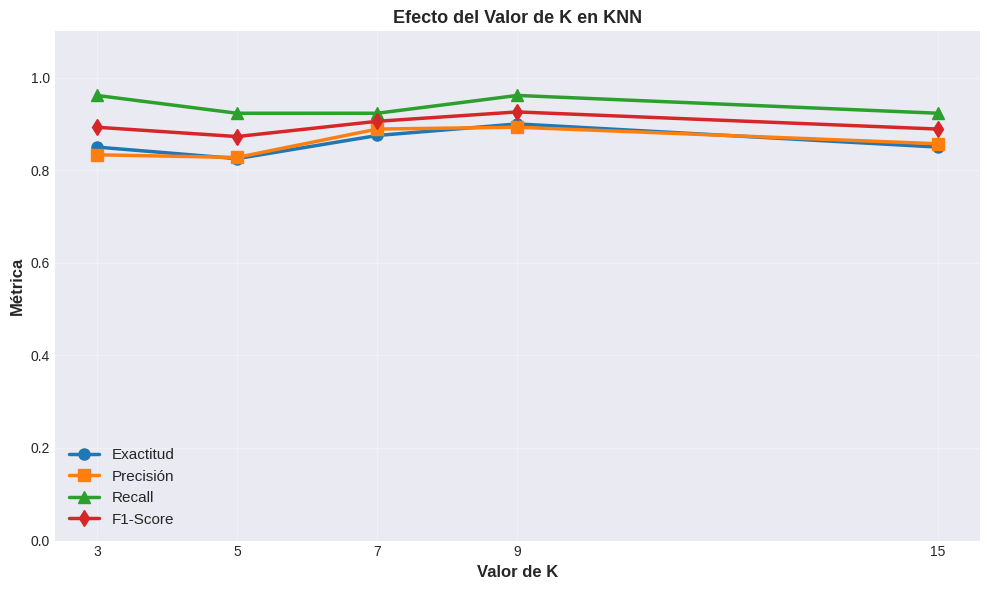

✓ Gráfico completado


In [7]:
# Visualizar efecto de K
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_knn['K'], df_knn['Exactitud'], 'o-', linewidth=2.5, markersize=8, label='Exactitud')
ax.plot(df_knn['K'], df_knn['Precisión'], 's-', linewidth=2.5, markersize=8, label='Precisión')
ax.plot(df_knn['K'], df_knn['Recall'], '^-', linewidth=2.5, markersize=8, label='Recall')
ax.plot(df_knn['K'], df_knn['F1-Score'], 'd-', linewidth=2.5, markersize=8, label='F1-Score')

ax.set_xlabel('Valor de K', fontweight='bold', fontsize=12)
ax.set_ylabel('Métrica', fontweight='bold', fontsize=12)
ax.set_title('Efecto del Valor de K en KNN', fontweight='bold', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(df_knn['K'])
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()
print("✓ Gráfico completado")

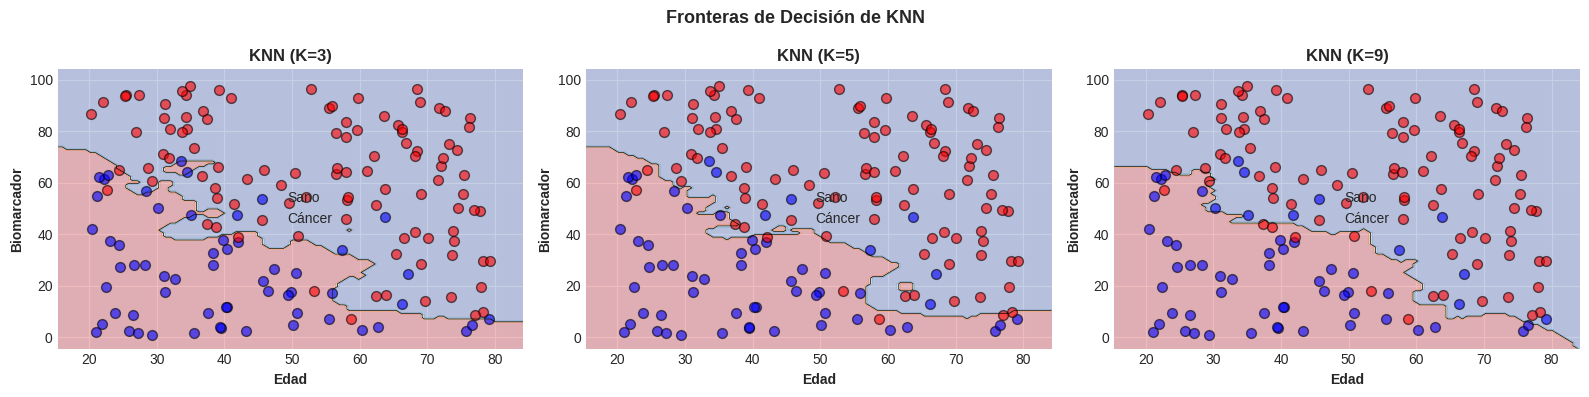

✓ Visualización de fronteras completada


In [20]:
# Visualizar decisiones de KNN en 2D
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

k_viz = [3, 5, 9]

for idx, k in enumerate(k_viz):
    ax = axes[idx]
    
    # Crear malla de puntos
    x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
    y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Contorno de decisión
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    ax.contour(xx, yy, Z, colors='black', linewidths=0.5, levels=[0.5])
    
    # Datos
    ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
              c='blue', label='Sano', s=50, alpha=0.6, edgecolors='black')
    ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
              c='red', label='Cáncer', s=50, alpha=0.6, edgecolors='black')
    
    ax.set_xlabel('Edad', fontweight='bold')
    ax.set_ylabel('Biomarcador', fontweight='bold')
    ax.set_title(f'KNN (K={k})', fontweight='bold')
    ax.legend()

plt.suptitle('Fronteras de Decisión de KNN', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print("✓ Visualización de fronteras completada")

## 3. Árbol de Decisión

### Concepto

Divide el espacio de características en regiones rectangulares usando divisiones binarias recursivas.

**Algoritmo:**
1. Seleccionar feature y threshold que mejor divide datos
2. Repetir en cada rama hasta criterio de parada
3. Asignar clase mayoritaria en cada hoja

**Ventajas:**
- Muy interpretable
- Captura no linealidades
- No requiere escalado
- Maneja variables categóricas

**Desventajas:**
- Propenso a sobreajuste (especialmente profundo)
- Inestable (pequeños cambios → grandes cambios)
- Puede ser sesgado con clases desbalanceadas

In [9]:
# Probar diferentes profundidades
max_depths = [2, 3, 5, 7, 10]

print("ÁRBOL DE DECISIÓN CON DIFERENTES PROFUNDIDADES")
print("="*60)

dt_modelos = {}
dt_resultados = []

for depth in max_depths:
    # Entrenar
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = dt.predict(X_train)
    y_pred_test = dt.predict(X_test)
    y_proba = dt.predict_proba(X_test)[:, 1]
    
    # Métricas
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    dt_modelos[depth] = (dt, y_pred_test, y_proba)
    dt_resultados.append({
        'Profundidad': depth,
        'Entrenamiento': acc_train,
        'Prueba': acc_test,
        'Precisión': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\nProfundidad = {depth}")
    print(f"  Exactitud Entrenamiento: {acc_train:.4f}")
    print(f"  Exactitud Prueba: {acc_test:.4f}")
    print(f"  Diferencia (sobreajuste): {(acc_train - acc_test):.4f}")
    print(f"  F1-Score: {f1:.4f}")

df_dt = pd.DataFrame(dt_resultados)
mejor_depth = df_dt.loc[df_dt['F1-Score'].idxmax(), 'Profundidad']
print(f"\n✓ Mejor profundidad: {int(mejor_depth)}")

ÁRBOL DE DECISIÓN CON DIFERENTES PROFUNDIDADES

Profundidad = 2
  Exactitud Entrenamiento: 0.8875
  Exactitud Prueba: 0.7750
  Diferencia (sobreajuste): 0.1125
  F1-Score: 0.8421

Profundidad = 3
  Exactitud Entrenamiento: 0.9313
  Exactitud Prueba: 0.7750
  Diferencia (sobreajuste): 0.1562
  F1-Score: 0.8421

Profundidad = 5
  Exactitud Entrenamiento: 0.9812
  Exactitud Prueba: 0.8250
  Diferencia (sobreajuste): 0.1562
  F1-Score: 0.8772

Profundidad = 7
  Exactitud Entrenamiento: 1.0000
  Exactitud Prueba: 0.8250
  Diferencia (sobreajuste): 0.1750
  F1-Score: 0.8772

Profundidad = 10
  Exactitud Entrenamiento: 1.0000
  Exactitud Prueba: 0.8250
  Diferencia (sobreajuste): 0.1750
  F1-Score: 0.8772

✓ Mejor profundidad: 5


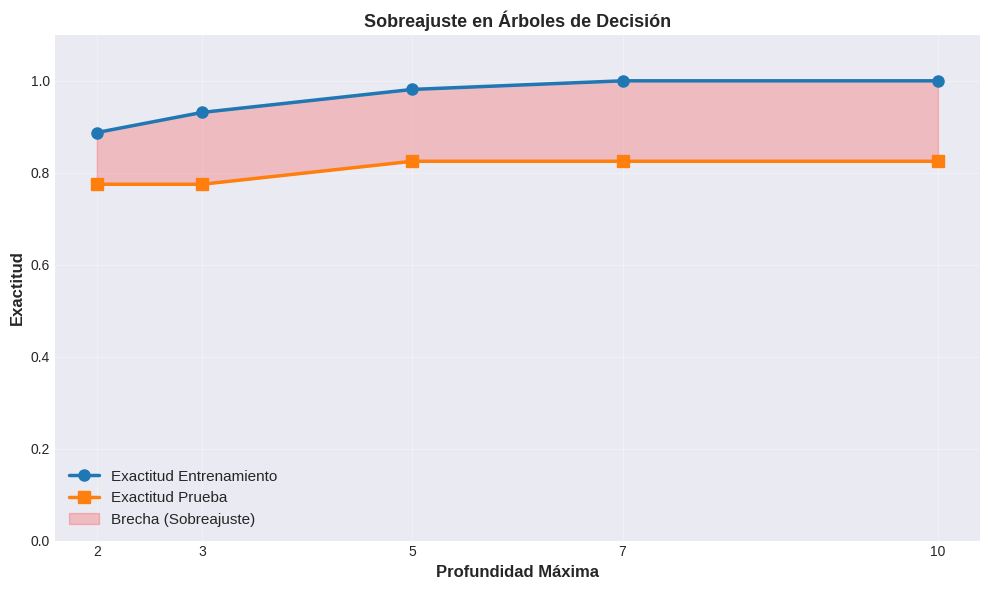

✓ Gráfico de sobreajuste completado


In [21]:
# Visualizar sobreajuste
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_dt['Profundidad'], df_dt['Entrenamiento'], 'o-', linewidth=2.5, 
        markersize=8, label='Exactitud Entrenamiento')
ax.plot(df_dt['Profundidad'], df_dt['Prueba'], 's-', linewidth=2.5, 
        markersize=8, label='Exactitud Prueba')
ax.fill_between(df_dt['Profundidad'], df_dt['Entrenamiento'], df_dt['Prueba'], 
                 alpha=0.2, color='red', label='Brecha (Sobreajuste)')

ax.set_xlabel('Profundidad Máxima', fontweight='bold', fontsize=12)
ax.set_ylabel('Exactitud', fontweight='bold', fontsize=12)
ax.set_title('Sobreajuste en Árboles de Decisión', fontweight='bold', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.1])
ax.set_xticks(df_dt['Profundidad'])

plt.tight_layout()
plt.show()
print("✓ Gráfico de sobreajuste completado")

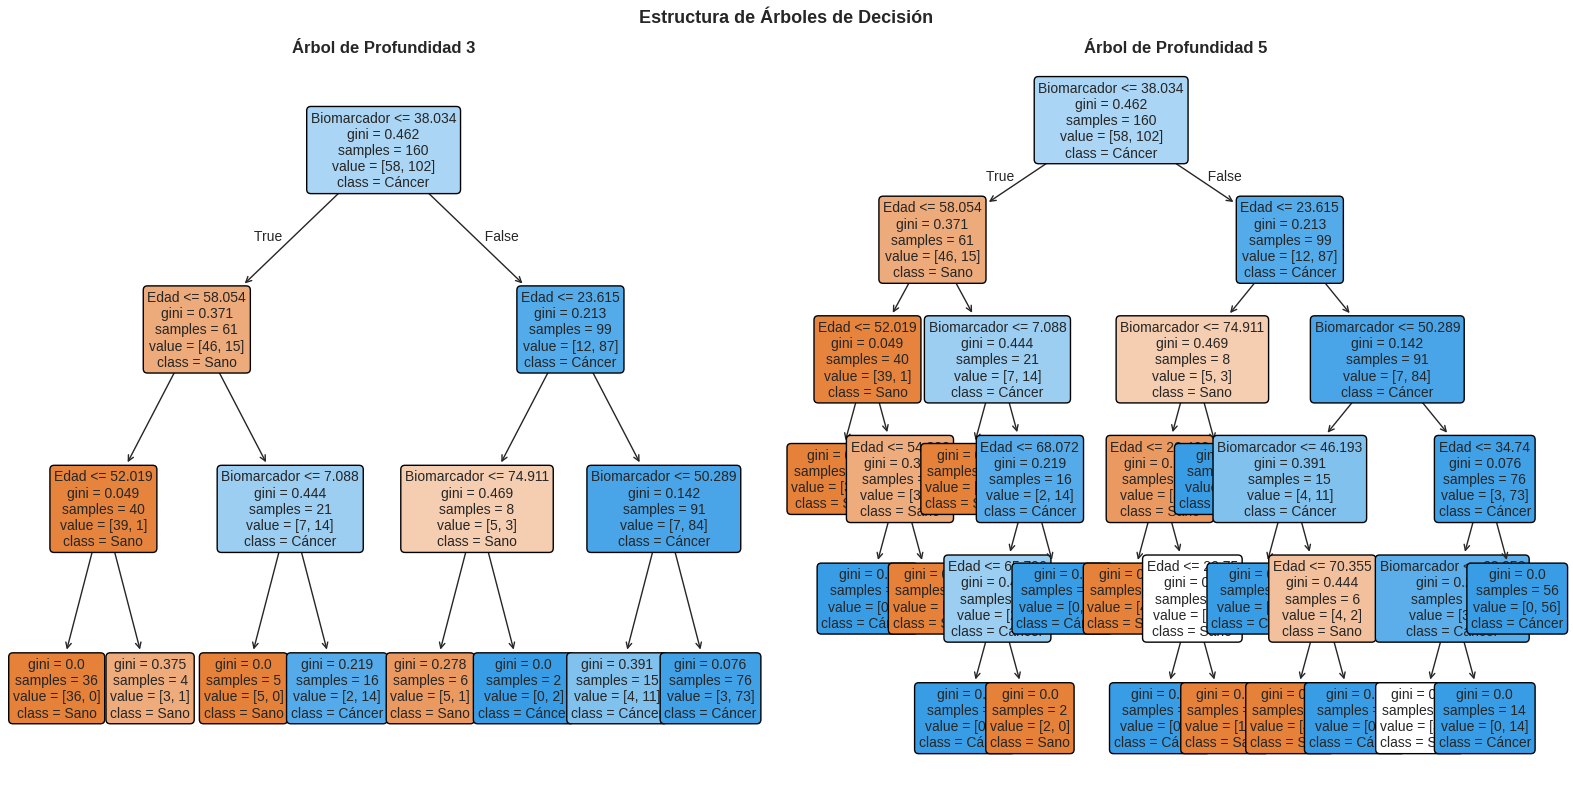

✓ Visualización de árboles completada


In [22]:
# Visualizar árbol (pequeño y mediano)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for idx, depth in enumerate([3, 5]):
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    plot_tree(dt, ax=axes[idx], 
             feature_names=['Edad', 'Biomarcador'],
             class_names=['Sano', 'Cáncer'],
             filled=True, rounded=True, fontsize=10)
    
    axes[idx].set_title(f'Árbol de Profundidad {depth}', fontweight='bold', fontsize=12)

plt.suptitle('Estructura de Árboles de Decisión', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print("✓ Visualización de árboles completada")

## 2. Árboles de Decisión

### ¿Cómo funciona?

Como un juego de 20 preguntas:

```
¿Edad > 50?
├─ Sí → ¿Biomarcador > 60?
│        ├─ Sí → CÁNCER
│        └─ No → SANO
└─ No → ¿Biomarcador > 80?
         ├─ Sí → CÁNCER
         └─ No → SANO
```

**Ventajas:**
- Muy interpretable (entiendes el por qué)
- Maneja relaciones no lineales
- No necesita escalado de datos

**Desventajas:**
- Fácil de sobreajustar
- Pequeños cambios en datos → resultados muy diferentes

In [23]:
# Entrenar Bosque Aleatorio
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Métricas
acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf)
rec = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print("BOSQUE ALEATORIO")
print("="*60)
print(f"Número de árboles: 100")
print(f"Profundidad máxima: 5")
print(f"\nMétricas:")
print(f"  Exactitud: {acc:.4f}")
print(f"  Precisión: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  F1-Score: {f1:.4f}")

print(f"\nImportancia de características:")
for feature, importance in zip(['Edad', 'Biomarcador'], rf.feature_importances_):
    print(f"  {feature}: {importance:.4f} ({importance*100:.1f}%)")

BOSQUE ALEATORIO
Número de árboles: 100
Profundidad máxima: 5

Métricas:
  Exactitud: 0.8250
  Precisión: 0.8065
  Recall: 0.9615
  F1-Score: 0.8772

Importancia de características:
  Edad: 0.3785 (37.9%)
  Biomarcador: 0.6215 (62.1%)


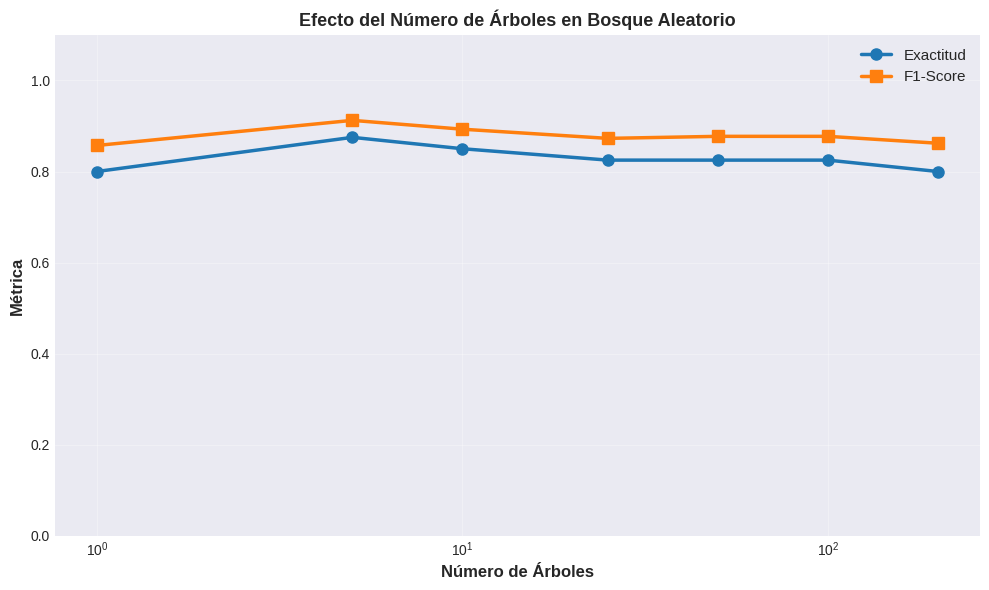

✓ Gráfico completado


In [24]:
# Efecto del número de árboles
n_trees = [1, 5, 10, 25, 50, 100, 200]

rf_resultados = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    rf_resultados.append({
        'n_estimators': n,
        'Exactitud': acc,
        'F1-Score': f1
    })

df_rf = pd.DataFrame(rf_resultados)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_rf['n_estimators'], df_rf['Exactitud'], 'o-', linewidth=2.5, 
        markersize=8, label='Exactitud')
ax.plot(df_rf['n_estimators'], df_rf['F1-Score'], 's-', linewidth=2.5, 
        markersize=8, label='F1-Score')

ax.set_xlabel('Número de Árboles', fontweight='bold', fontsize=12)
ax.set_ylabel('Métrica', fontweight='bold', fontsize=12)
ax.set_title('Efecto del Número de Árboles en Bosque Aleatorio', fontweight='bold', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.1])
ax.set_xscale('log')

plt.tight_layout()
plt.show()
print("✓ Gráfico completado")

## 3. Bosque Aleatorio (Random Forest)

### ¿Cómo funciona?

"Muchas cabezas piensan mejor que una."

**Idea:**
1. Crea 100 árboles de decisión, cada uno viendo datos un poco diferentes
2. Cada árbol hace una predicción
3. La mayoría vota y gana

**Ejemplo:** Si 70 árboles dicen "CÁNCER" y 30 dicen "SANO", la predicción es CÁNCER.

**Ventajas:**
- Robusto (muchos árboles votan)
- No se sobreajusta tan fácilmente
- Mejor precisión general

**Desventajas:**
- Menos interpretable (100 árboles es mucho para entender)
- Más lento que un árbol único

In [25]:
# Normalizar características para SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("SVM CON DIFERENTES KERNELS")
print("="*60)

kernels = ['linear', 'rbf', 'poly']
svm_modelos = {}
svm_resultados = []

for kernel in kernels:
    # Entrenar
    svm = SVC(kernel=kernel, probability=True, random_state=42)
    svm.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_pred = svm.predict(X_test_scaled)
    y_proba = svm.predict_proba(X_test_scaled)[:, 1]
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    svm_modelos[kernel] = (svm, y_pred, y_proba)
    svm_resultados.append({
        'Kernel': kernel,
        'Exactitud': acc,
        'Precisión': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Vectores_Soporte': svm.n_support_[0] + svm.n_support_[1]
    })
    
    print(f"\nKernel: {kernel}")
    print(f"  Exactitud: {acc:.4f}")
    print(f"  Precisión: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Vectores de Soporte: {svm.n_support_[0] + svm.n_support_[1]}")

df_svm = pd.DataFrame(svm_resultados)
mejor_kernel = df_svm.loc[df_svm['F1-Score'].idxmax(), 'Kernel']
print(f"\n✓ Mejor kernel: {mejor_kernel}")

SVM CON DIFERENTES KERNELS

Kernel: linear
  Exactitud: 0.9000
  Precisión: 0.8929
  Recall: 0.9615
  F1-Score: 0.9259
  Vectores de Soporte: 48

Kernel: rbf
  Exactitud: 0.9000
  Precisión: 0.8929
  Recall: 0.9615
  F1-Score: 0.9259
  Vectores de Soporte: 56

Kernel: poly
  Exactitud: 0.8500
  Precisión: 0.8125
  Recall: 1.0000
  F1-Score: 0.8966
  Vectores de Soporte: 61

✓ Mejor kernel: linear


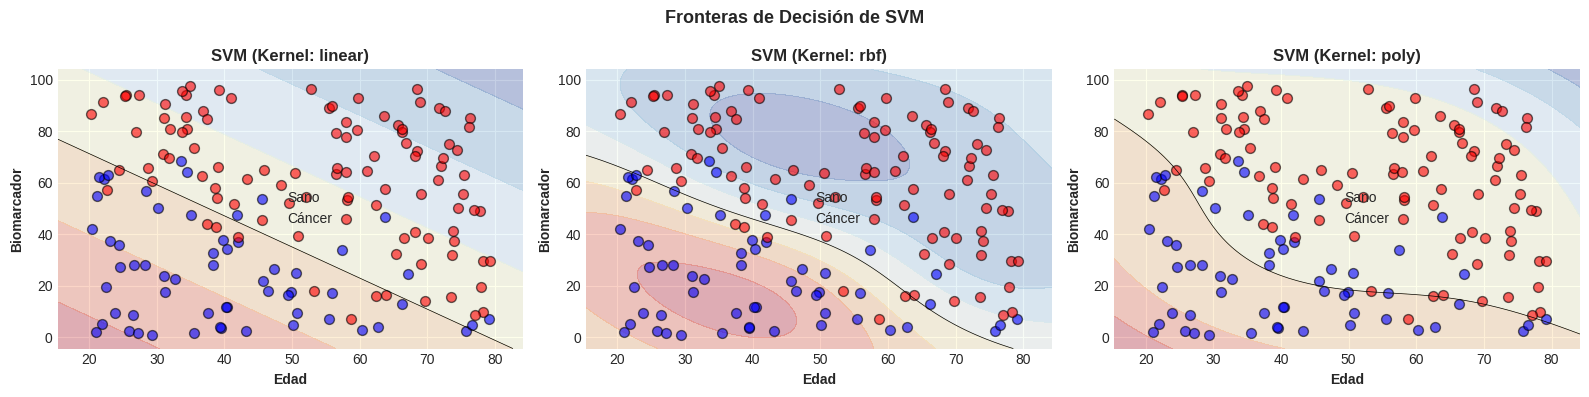

✓ Visualización completada


In [26]:
# Visualizar fronteras de SVM con diferentes kernels
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

kernels_viz = ['linear', 'rbf', 'poly']

for idx, kernel in enumerate(kernels_viz):
    ax = axes[idx]
    
    # Crear malla de puntos
    x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
    y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train_scaled, y_train)
    
    # Escalar malla
    xx_scaled = (xx - scaler.mean_[0]) / scaler.scale_[0]
    yy_scaled = (yy - scaler.mean_[1]) / scaler.scale_[1]
    
    Z = svm.decision_function(np.c_[xx_scaled.ravel(), yy_scaled.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Contorno de decisión
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    ax.contour(xx, yy, Z, colors='black', linewidths=0.5, levels=[0])
    
    # Datos
    ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
              c='blue', label='Sano', s=50, alpha=0.6, edgecolors='black')
    ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
              c='red', label='Cáncer', s=50, alpha=0.6, edgecolors='black')
    
    ax.set_xlabel('Edad', fontweight='bold')
    ax.set_ylabel('Biomarcador', fontweight='bold')
    ax.set_title(f'SVM (Kernel: {kernel})', fontweight='bold')
    ax.legend()

plt.suptitle('Fronteras de Decisión de SVM', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print("✓ Visualización completada")

## 6. Comparación de Todos los Algoritmos

In [27]:
# Preparar predicciones de los mejores modelos
knn_best = KNeighborsClassifier(n_neighbors=5)
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)

dt_best = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_best.fit(X_train, y_train)
y_pred_dt = dt_best.predict(X_test)

rf_best = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)

svm_best = SVC(kernel='rbf', random_state=42)
svm_best.fit(X_train_scaled, y_train)
y_pred_svm = svm_best.predict(X_test_scaled)

# Calcular métricas
resultados = []

algoritmos = [
    ('KNN (K=5)', y_pred_knn),
    ('Árbol (depth=5)', y_pred_dt),
    ('Bosque Aleatorio', y_pred_rf),
    ('SVM (RBF)', y_pred_svm)
]

for nombre, y_pred in algoritmos:
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    resultados.append({
        'Algoritmo': nombre,
        'Exactitud': acc,
        'Precisión': prec,
        'Recall': rec,
        'F1-Score': f1
    })

df_comparacion = pd.DataFrame(resultados)

print("\nCOMPARACIÓN DE ALGORITMOS AVANZADOS")
print("="*80)
print(df_comparacion.to_string(index=False))
print("="*80)


COMPARACIÓN DE ALGORITMOS AVANZADOS
       Algoritmo  Exactitud  Precisión   Recall  F1-Score
       KNN (K=5)      0.825   0.827586 0.923077  0.872727
 Árbol (depth=5)      0.825   0.806452 0.961538  0.877193
Bosque Aleatorio      0.825   0.806452 0.961538  0.877193
       SVM (RBF)      0.900   0.892857 0.961538  0.925926


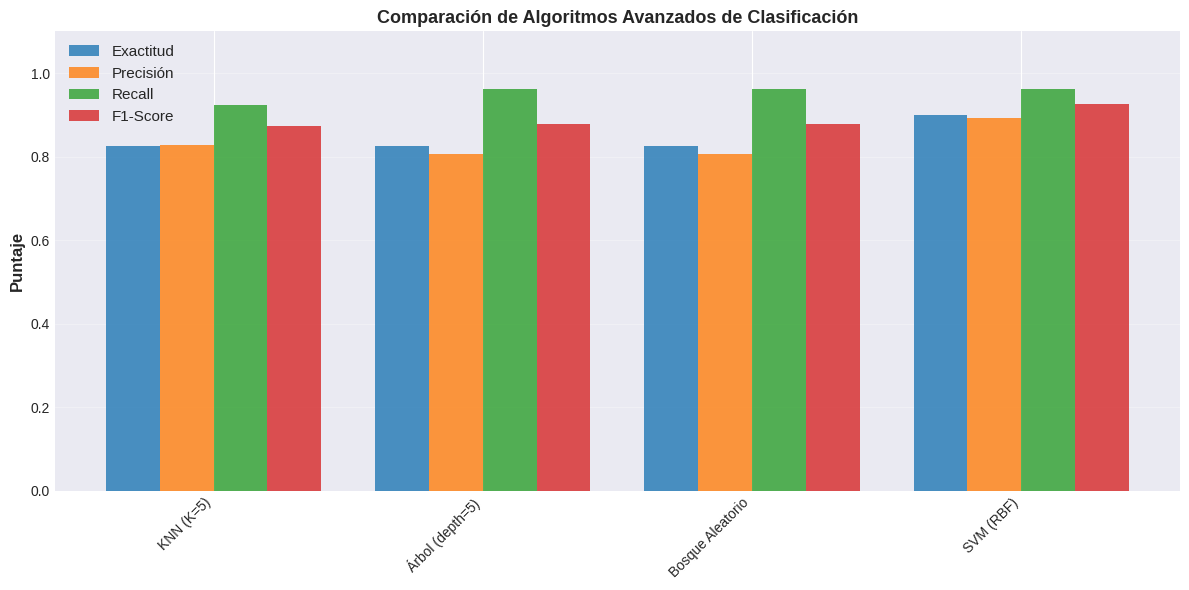

✓ Gráfico completado


In [28]:
# Gráfico comparativo
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_comparacion))
width = 0.2

ax.bar(x - 1.5*width, df_comparacion['Exactitud'], width, label='Exactitud', alpha=0.8)
ax.bar(x - 0.5*width, df_comparacion['Precisión'], width, label='Precisión', alpha=0.8)
ax.bar(x + 0.5*width, df_comparacion['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + 1.5*width, df_comparacion['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_ylabel('Puntaje', fontweight='bold', fontsize=12)
ax.set_title('Comparación de Algoritmos Avanzados de Clasificación', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(df_comparacion['Algoritmo'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()
print("✓ Gráfico completado")

## 7. ¿Cuándo usar cada algoritmo?

### KNN
- Usa si: Datos pequeños, relaciones locales
- No uses si: Tienes millones de datos (será lento)

### Árbol de Decisión
- Usa si: Necesitas explicar por qué clasifica así
- No uses si: Quieres máxima precisión

### Bosque Aleatorio  
- Usa si: Quieres buena precisión con datos medianos
- Este es la mejor opción para la mayoría de casos

### SVM
- Usa si: Datos complejos y no muy grandes
- No uses si: Necesitas explicabilidad

### Regla de oro:
- Prueba primero: **Regresión Logística** (simple)
- Luego: **Bosque Aleatorio** (robusto)
- Si nada funciona: Consulta a un experto